In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
from tqdm import tqdm

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))

In [16]:
def sk_tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, band_count))
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                # somehow we're randomly getting tiles without the correct dimensions
                # I assume it is when the tiles are on the edge
                pass
            else:
                tile = adjust_band(tile)
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile[tile_width//2,tile_height//2,:].flatten()
                    b += 1
        return (image_batch, label_batch)

In [13]:
l = np.eye(11)
print(l)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [4]:
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count_per_dataset)
        
        dataset_index_list = [index] * total_count_per_dataset
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_pixels += dataset_pixels[:train_count_per_dataset]
        val_pixels += dataset_pixels[train_count_per_dataset:]
        
        
    return (train_pixels, val_pixels)

In [5]:
train_px, _ = gen_pixel_locations(landsat_datasets, 50000, 0, 11)

100%|██████████| 4/4 [01:03<00:00, 16.13s/it]


In [17]:
batch_size = 50000
sk_im_batch, sk_label_batch = sk_tile_generator(landsat_datasets, label_dataset, 11, 11, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

(50000, 8) (50000, 23)


In [27]:
np.sum(sk_im_batch[:,7])

3990.583386245138

In [28]:
from sklearn.decomposition import PCA
pca = PCA().fit(sk_im_batch)

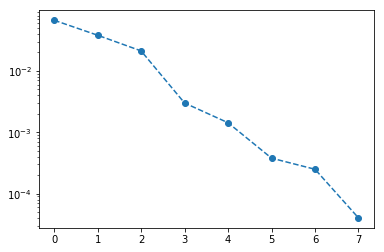

In [30]:
plt.semilogy(pca.explained_variance_, '--o')

In [33]:
from sklearn.feature_selection import SelectKBest, chi2
sk_im_batch_new = SelectKBest(chi2, k=3).fit_transform(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [34]:
sk_im_batch_new.shape

(50000, 3)